### 8.1.2 Modularization

In [243]:
getwd()

[1] "/root"

In [244]:
setwd("/root/")
dir()

[1] "README.md"                   "ch01.Rmd"                   
 [3] "ch01.nb.html"                "ch02.Rmd"                   
 [5] "ch02.nb.html"                "ch03.Rmd"                   
 [7] "ch03.nb.html"                "ch04.Rmd"                   
 [9] "ch04.nb.html"                "ch05.ipynb"                 
[11] "ch06.ipynb"                  "ch07.ipynb"                 
[13] "ch08.ipynb"                  "dataset"                    
[15] "lagp-benchmark.ipynb"        "study-surrogates-2020.Rproj"
[17] "test-linear.Rmd"             "test-linear.nb.html"

In [245]:
ball <- read.csv("dataset/ball.csv")

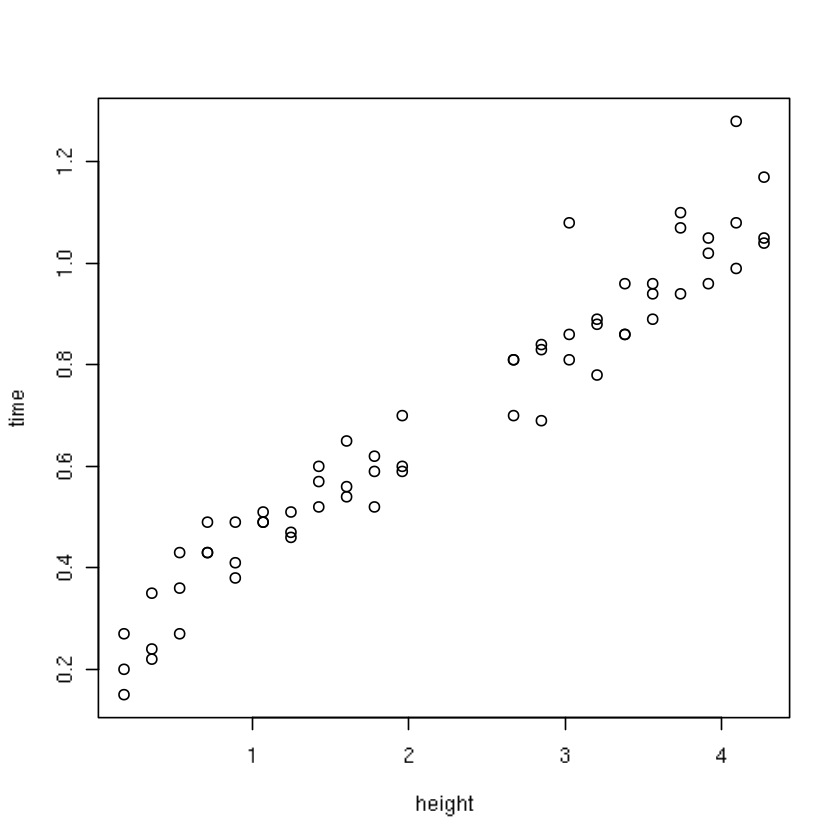

In [246]:
plot(ball, xlab="height", ylab="time")

In [247]:
library(tidyverse)

In [248]:
ball %>% group_by(height) %>% count()

height,n
<dbl>,<int>
0.178,3
0.356,3
0.534,3
0.712,3
0.890,3
1.068,3
1.246,3
1.424,3
1.602,3


In [249]:
mod1 <- (lm(time ~ height, data = ball))
summary(mod1)


Call:
lm(formula = time ~ height, data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.126672 -0.056838 -0.003417  0.037480  0.227148 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.237803   0.017314   13.73   <2e-16 ***
height      0.203255   0.006727   30.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07024 on 61 degrees of freedom
Multiple R-squared:  0.9374,	Adjusted R-squared:  0.9363 
F-statistic:   913 on 1 and 61 DF,  p-value: < 2.2e-16


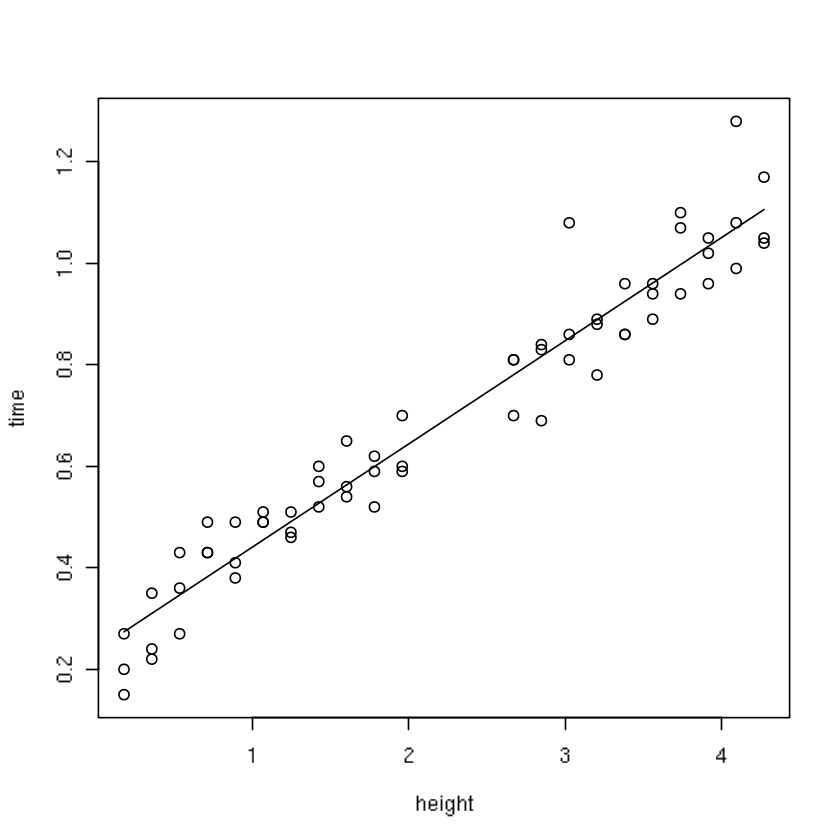

In [250]:
plot(ball)
lines(ball$height, predict(mod1))

In [251]:
mod2 <- (lm(time ~ sqrt(height), data = ball))
summary(mod2)


Call:
lm(formula = time ~ sqrt(height), data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.150620 -0.055470 -0.005667  0.037101  0.258835 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.06683    0.02876  -2.324   0.0235 *  
sqrt(height)  0.53772    0.01934  27.810   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07589 on 61 degrees of freedom
Multiple R-squared:  0.9269,	Adjusted R-squared:  0.9257 
F-statistic: 773.4 on 1 and 61 DF,  p-value: < 2.2e-16


In [252]:
2 / coef(mod2)[2]^2

sqrt(height) 
    6.917062

In [253]:
mod3 <- (lm(time ~ sqrt(height) - 1, data = ball))
summary(mod3)


Call:
lm(formula = time ~ sqrt(height) - 1, data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.145937 -0.058144 -0.006645  0.022872  0.277747 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
sqrt(height) 0.495340   0.006653   74.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07854 on 62 degrees of freedom
Multiple R-squared:  0.9889,	Adjusted R-squared:  0.9888 
F-statistic:  5544 on 1 and 62 DF,  p-value: < 2.2e-16


In [254]:
2 / coef(mod3)[1]^2

sqrt(height) 
    8.151226

In [255]:
install.packages("laGP")
library(laGP)
field.fit <- newGP(as.matrix(ball$height), ball$time, d=0.1,
                  g=var(ball$time)/10, dK=TRUE)
eps <- sqrt(.Machine$double.eps)
mle <- jmleGP(field.fit, drange=c(eps, 10), grange=c(eps, var(ball$time)),
             dab=c(3/2, 8))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [256]:
mle

d,g,tot.its,dits,gits
<dbl>,<dbl>,<int>,<int>,<int>
0.8967258,0.02108801,27,15,12


In [257]:
hr <- range(ball$height)
hs <- seq(0, 1, length=100)
heights <- hs*diff(hr) + hr[1]
p <- predGP(field.fit, as.matrix(heights), lite=TRUE)
deleteGP(field.fit)

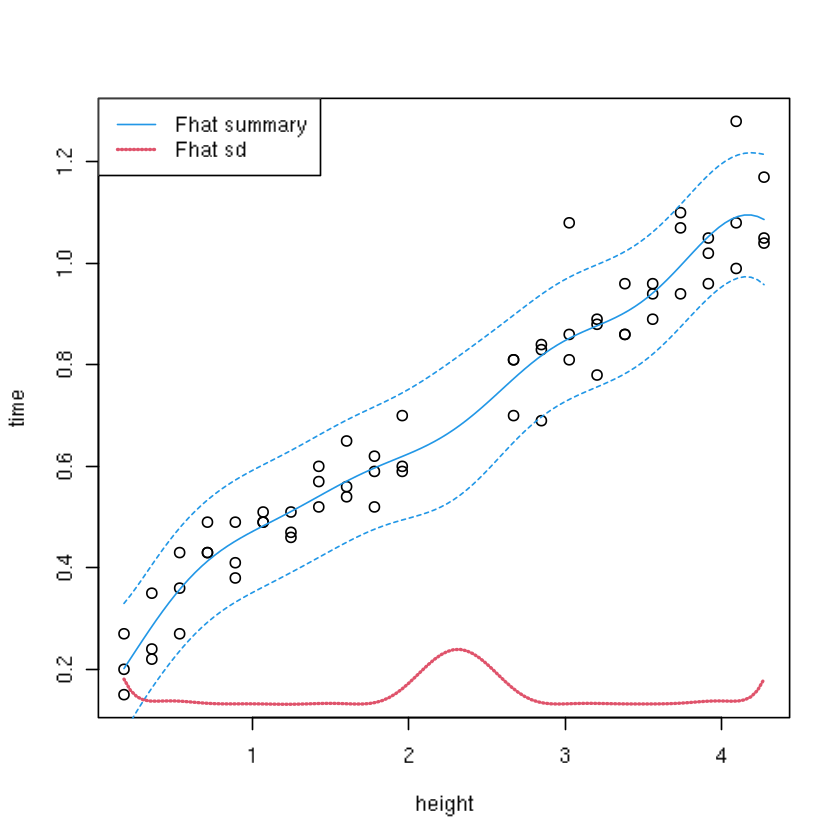

In [258]:
plot(ball, xlab="height", ylab="time")
lines(heights, p$mean, col=4)
lines(heights, qnorm(0.05, p$mean, sqrt(p$s2)), lty=2, col=4)
lines(heights, qnorm(0.95, p$mean, sqrt(p$s2)), lty=2, col=4)
lines(heights, 10*sqrt(p$s2)-0.6, col=2, lty=3, lwd=2)
legend("topleft", c("Fhat summary", "Fhat sd"), lty=c(1,3), 
  col=c(4,2), lwd=1:2)

In [259]:
timedrop <- function(x, u, hr, gr) {
  g <- diff(gr)*u + gr[1]
  h <- diff(hr)*x + hr[1]
  return(sqrt(2*h/g))
}

In [260]:
gr <- c(6, 14)

In [261]:
library(lhs)
XU <- maximinLHS(21, 2)
yM <- timedrop(XU[,1], XU[,2], hr, gr)

In [262]:
yMhat <- newGPsep(XU, yM, d=0.1, g=1e-7, dK=TRUE)
mle <- mleGPsep(yMhat, tmin=eps, tmax=10)

In [263]:
mle

$d
[1] 0.8467171 7.2037805

$its
[1] 35

$msg
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$conv
[1] 0

In [264]:
us <- seq(0, 1, length=6)
XX <- expand.grid(hs, us)
pm <- predGPsep(yMhat, XX, lite=TRUE)
str(pm)

List of 4
 $ mean: num [1:600] 0.262 0.281 0.3 0.319 0.337 ...
 $ s2  : num [1:600] 4.56e-06 4.04e-06 3.74e-06 3.61e-06 3.57e-06 ...
 $ df  : num 21
 $ llik: num 60.4


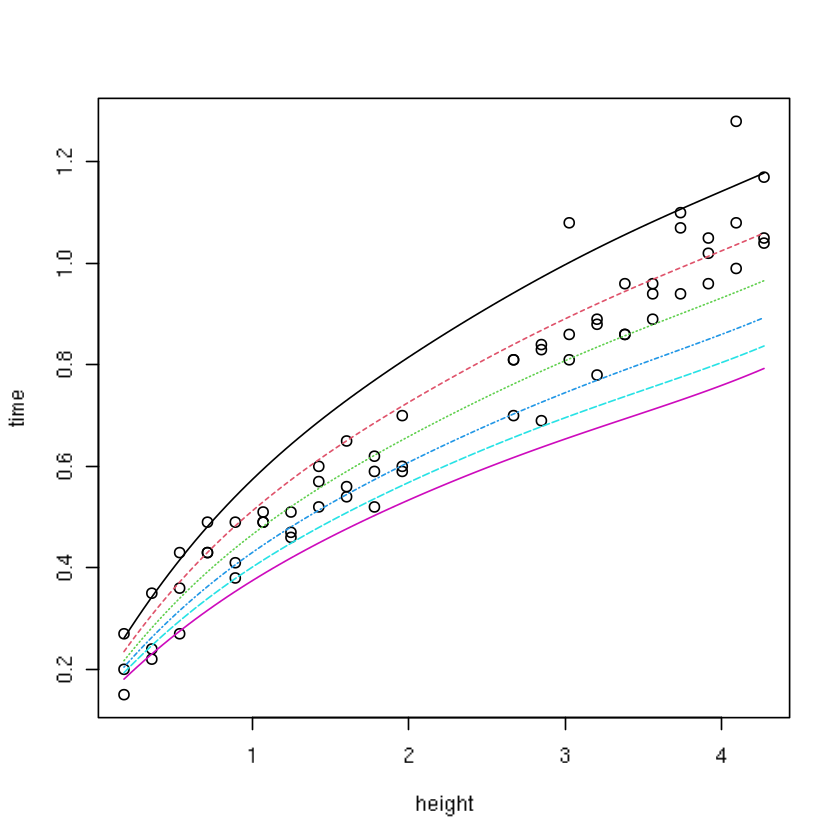

In [265]:
plot(ball)
matlines(heights, matrix(pm$m, ncol=length(us)))

In [266]:
bhat.fit <- function(X, yF, Ym, da, ga, clean=TRUE)
 {
  bhat <- newGPsep(X, yF - Ym, d=da$start, g=ga$start, dK=TRUE)
  if(ga$mle) {
    cmle <- mleGPsep(bhat, param="both", tmin=c(da$min, ga$min),
                     tmax=c(da$max, ga$max), ab=c(da$ab, ga$ab))
  } else {
    cmle <- mleGPsep(bhat, tmin=da$min, tmax=da$max, ab=da$ab)
  }
  cmle$nll <- - llikGPsep(bhat, dab=da$ab, gab=ga$ab)
  if(clean) deleteGPsep(bhat)
  else { cmle$gp <- bhat; cmle$gptype <- "sep" }        
  return(cmle)
 }

In [267]:
calib <- function(u, XF, yF, yMhat, fit, clean=TRUE)
 {
  XFu <- cbind(XF, matrix(rep(u, nrow(XF)), ncol=length(u), byrow=TRUE))
  Ym <- predGPsep(yMhat, XFu, lite=TRUE)$mean
  cmle <- fit(XF, yF, Ym, clean=clean)
  return(cmle)
 }

In [268]:
u <- seq(0, 1, length=100)
XF <- as.matrix((ball$height - hr[1])/diff(hr))

In [269]:
formals(bhat.fit)$da <- darg(d=list(mle=TRUE), X=XF)
formals(bhat.fit)$ga <- garg(g=list(mle=TRUE), y=ball$time)

In [270]:
#darg(d=list(mle=TRUE), X=XF)
#garg(g=list(mle=TRUE), y=ball$time)
formals(bhat.fit)

$X


$yF


$Ym


$da
$da$mle
[1] TRUE

$da$start
[1] 0.007561437

$da$max
[1] 1

$da$min
[1] 0.0009451796

$da$ab
[1] 1.500000 3.907364


$ga
$ga$mle
[1] TRUE

$ga$start
[1] 0.0001572436

$ga$max
[1] 0.3511033

$ga$min
[1] 1.490116e-08

$ga$ab
[1]  1.50000 51.22446


$clean
[1] TRUE


In [271]:
unll <- rep(NA, length(u))
for(i in 1:length(u)) 
  unll[i] <- calib(u[i], XF, ball$time, yMhat, bhat.fit)$nll

In [272]:
obj <- function(x, XF, yF, yMhat, fit) calib(x, XF, yF, yMhat, fit)$nll
soln <- optimize(obj, lower=0, upper=1, XF=XF, yF=ball$time, 
  yMhat=yMhat, fit=bhat.fit)
uhat <- soln$minimum

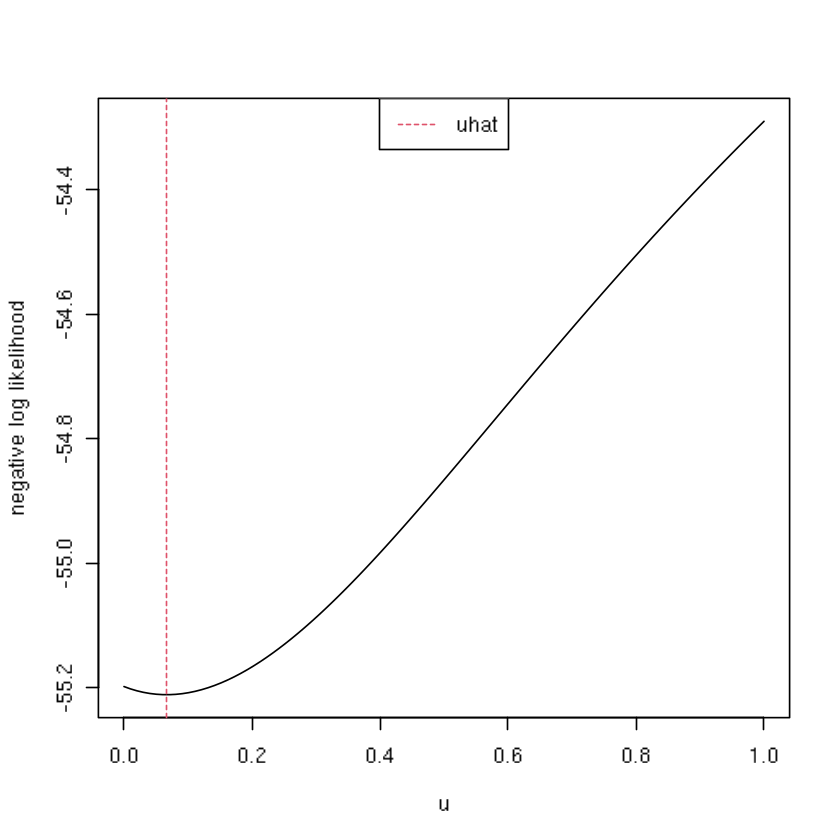

In [273]:
plot(u, unll, type="l", xlab="u", ylab="negative log likelihood")
abline(v=uhat, col=2, lty=2)
legend("top", "uhat", lty=2, col=2)

In [274]:
ghat <- uhat*diff(gr) + gr[1]
ghat

[1] 6.532539

In [275]:
ghat <- uhat*diff(gr) + gr[1]
ghat

[1] 6.532539

### 8.1.3 Calibration as optimization

In [276]:
bhat <- calib(uhat, XF, ball$time, yMhat, bhat.fit, clean=FALSE)

In [277]:
bhat

$theta
[1] 0.54416773 0.04326524

$its
[1] 20

$msg
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$conv
[1] 0

$nll
[1] -55.21153

$gp
[1] 12

$gptype
[1] "sep"

In [278]:
pb <- predGPsep(bhat$gp, as.matrix(hs), nonug=TRUE)
sb <- sqrt(diag(pb$Sigma))
q1b <- qnorm(0.95, pb$mean, sb)
q2b <- qnorm(0.05, pb$mean, sb)

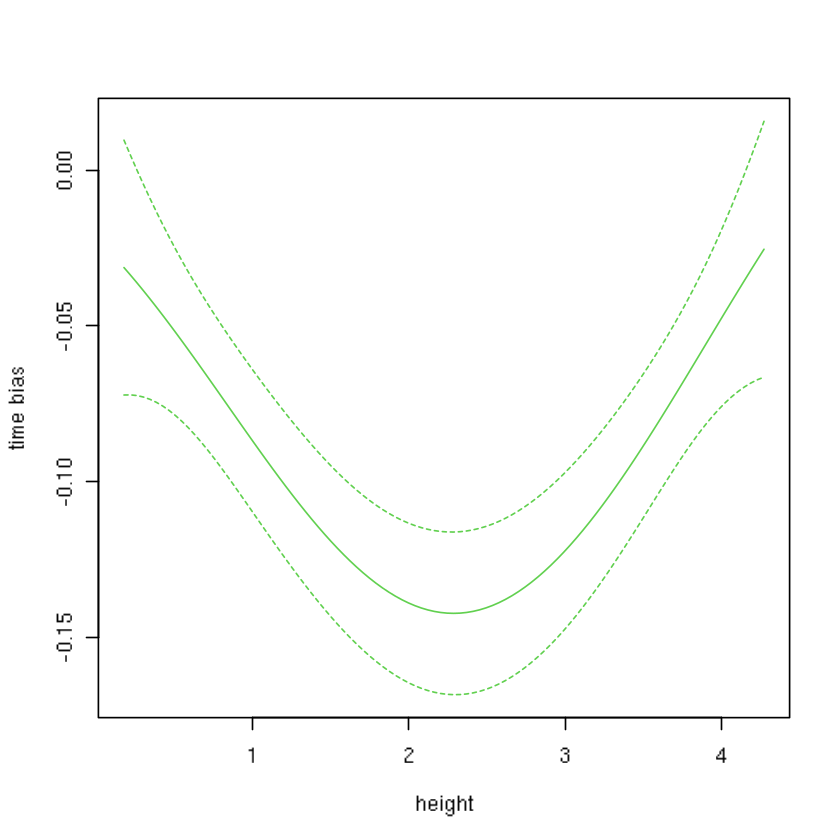

In [279]:
plot(heights, pb$mean, type="l", xlab="height", ylab="time bias", 
  ylim=range(c(q1b, q2b)), col=3)
lines(heights, q1b, col=3, lty=2)
lines(heights, q2b, col=3, lty=2) 

In [280]:
pm <- predGPsep(yMhat, cbind(hs, uhat))
q1m <- qnorm(0.95, pm$mean, sqrt(diag(pm$Sigma)))
q2m <- qnorm(0.05, pm$mean, sqrt(diag(pm$Sigma)))

In [281]:
m <- pm$mean + pb$mean
Sigma.Rhat <- pm$Sigma + pb$Sigma - diag(eps, length(m))

In [282]:
library(mvtnorm)
yR <- rmvnorm(30, m, Sigma.Rhat)

In [283]:
pbs2 <- predGPsep(bhat$gp, as.matrix(hs))
s <- sqrt(diag(pm$Sigma + pbs2$Sigma))
q1 <- qnorm(0.95, m, s)
q2 <- qnorm(0.05, m, s)
deleteGPsep(bhat$gp)

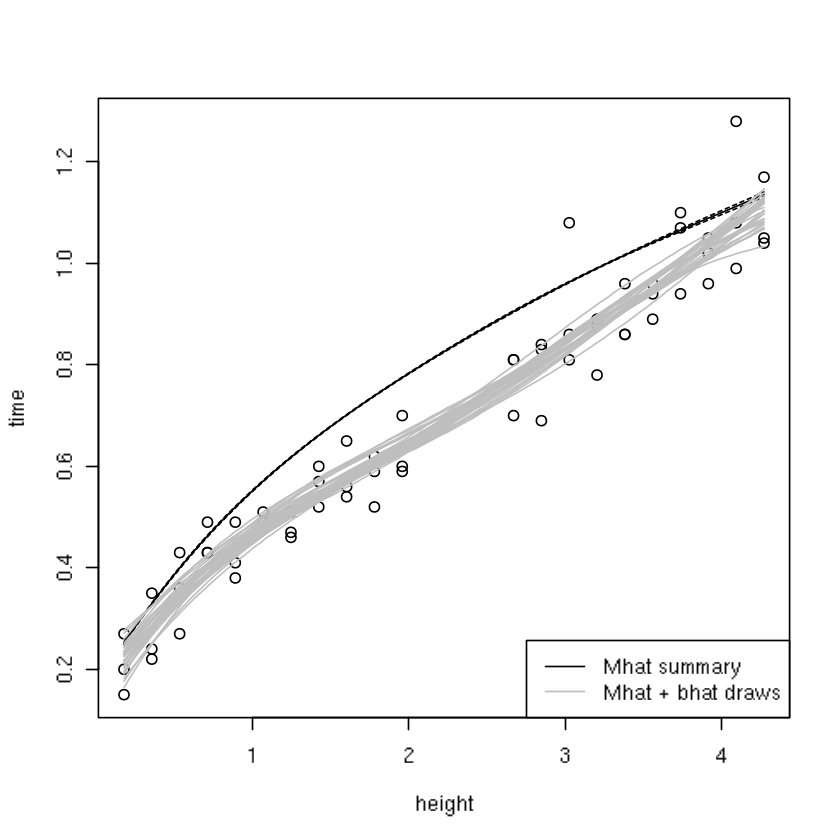

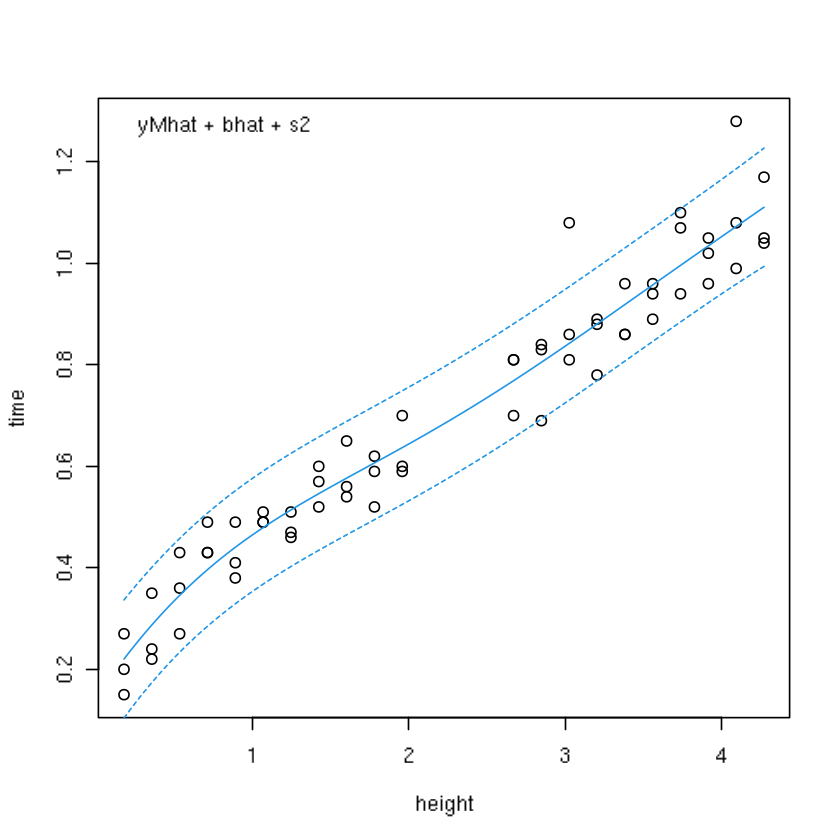

In [284]:
#par(mfrow=c(1,2), pty="s")
plot(ball)
lines(heights, pm$mean)
lines(heights, q1m, lty=2)
lines(heights, q2m, lty=2)
matlines(heights, t(yR), col="gray", lty=1)
legend("bottomright", c("Mhat summary", "Mhat + bhat draws"), 
  lty=c(1,1), col=c("black", "gray"))
plot(ball)
lines(heights, pm$mean + pb$mean, col=4)
lines(heights, q1, col=4, lty=2)
lines(heights, q2, col=4, lty=2)
legend("topleft", "yMhat + bhat + s2", bty="n")

### 8.1.4 Removing bias

In [285]:
se2.fit <- function(X, yF, Ym, clean=TRUE) {
  gp <- newGP(X, yF - Ym, d=0, g=0)
  cmle <- list(nll=-llikGP(gp))
  if (clean) {
    deleteGP(gp)
  } else {
    cmle$gp <- gp
    cmle$gptype <- "iso"
  }
  return(cmle)
}

In [286]:
unll.se2 <- rep(NA, length(u))
for(i in 1:length(u)) 
  unll.se2[i] <- calib(u[i], XF, ball$time, yMhat, fit=se2.fit)$nll
obj.nobias <- function(x, XF, yF, yMhat, fit) 
  calib(x, XF, yF, yMhat, fit)$nll
soln <- optimize(obj.nobias, lower=0, upper=1, XF=XF, yF=ball$time, 
  yMhat=yMhat, fit=se2.fit)
uhat.nobias <- soln$minimum

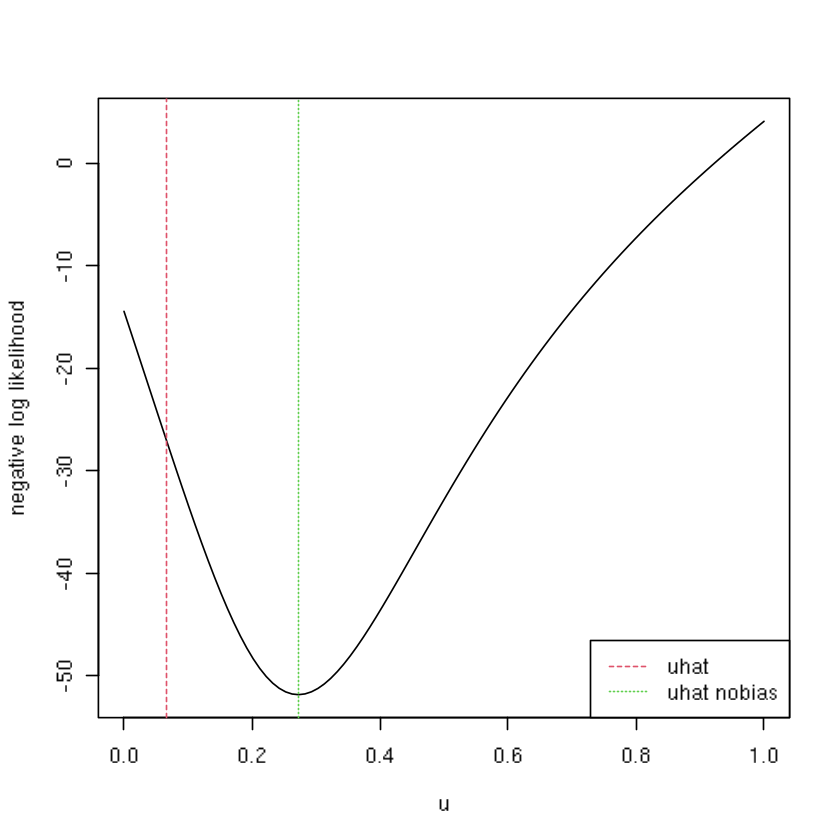

In [287]:
plot(u, unll.se2, type="l", xlab="u", ylab="negative log likelihood")
abline(v=uhat, col=2, lty=2)
abline(v=uhat.nobias, col=3, lty=3)
legend("bottomright", c("uhat", "uhat nobias"), lty=2:3, col=2:3)

In [288]:
ghat.nobias <- uhat.nobias*diff(gr) + gr[1]
ghat.nobias

[1] 8.178577

In [289]:
cmle.nobias <- calib(uhat.nobias, XF, ball$time, yMhat, 
  se2.fit, clean=FALSE)
se2.p <- predGP(cmle.nobias$gp, as.matrix(hs), lite=TRUE)
pm.nobias <- predGPsep(yMhat, cbind(hs, uhat.nobias), lite=TRUE)
q1nob <- qnorm(0.05, pm.nobias$mean, sqrt(pm.nobias$s2 + se2.p$s2))
q2nob <- qnorm(0.95, pm.nobias$mean, sqrt(pm.nobias$s2 + se2.p$s2))
deleteGP(cmle.nobias$gp)

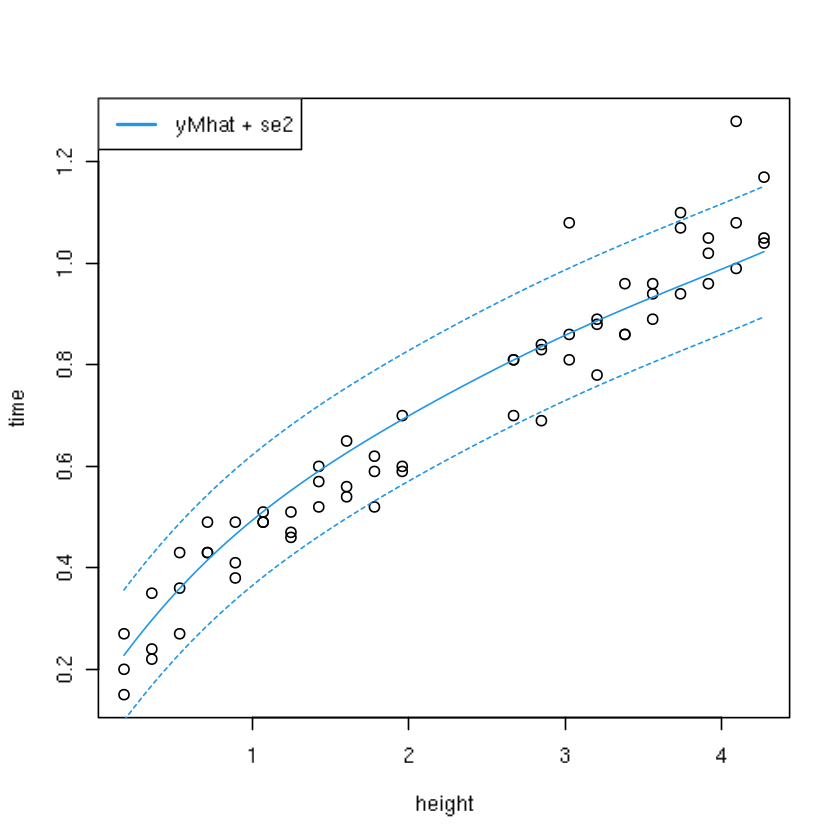

In [290]:
plot(ball)
lines(heights, pm.nobias$mean, col=4)
lines(heights, q1nob, col=4, lty=2)
lines(heights, q2nob, col=4, lty=2)
legend("topleft", c("yMhat + se2"), col=4, lty=1, lwd=2)

In [291]:
calib.pred <- function(XX, XF, yF, yMhat, fit)
 {
  soln <- optimize(obj, lower=0, upper=1, XF=XF, yF=yF, 
    yMhat=yMhat, fit=fit)
  bhat <- calib(soln$minimum, XF, yF, yMhat, fit, clean=FALSE)
  if(bhat$gptype == "sep") pb <- predGPsep(bhat$gp, XX, lite=TRUE)
  else pb <- predGP(bhat$gp, XX, lite=TRUE)
  pm <- predGPsep(yMhat, cbind(XX, soln$minimum), lite=TRUE)
  m <- pm$mean + pb$mean
  s2 <- pm$s2 + pb$s2 
  q1 <- qnorm(0.95, m, sqrt(s2))
  q2 <- qnorm(0.05, m, sqrt(s2))
  if(bhat$gptype == "sep") deleteGPsep(bhat$gp)
  else deleteGP(bhat$gp)
  return(list(mean=m, s2=s2, q1=q1, q2=q2, uhat=soln$minimum))
 }

In [292]:
uhats <- q1 <- q2 <- m <- s2 <- rep(NA, nrow(XF))
uhatsnb <- q1nb <- q2nb <- mnb <- s2nb <- uhats
for(i in 1:nrow(XF)) {
  train <- XF[-i,,drop=FALSE]
  test <- XF[i,,drop=FALSE]
  cp <- calib.pred(test, train, ball$time[-i], yMhat, bhat.fit)
  m[i] <- cp$mean
  s2[i] <- cp$s2 
  q1[i] <- cp$q1
  q2[i] <- cp$q2 
  uhats[i] <- cp$uhat
  cpnb <- calib.pred(test, train, ball$time[-i], yMhat, se2.fit)
  mnb[i] <- cpnb$mean
  s2nb[i] <- cpnb$s2
  q1nb[i] <- cpnb$q1
  q2nb[i] <- cpnb$q2
  uhatsnb[i] <- cpnb$uhat
}

In [293]:
rbind(u=summary(uhats), g=summary(uhats)*diff(gr) + gr[1])

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
u,0.03637716,0.06278863,0.06697093,0.0679747,0.0722372,0.1166575
g,6.29101725,6.50230903,6.53576742,6.5437976,6.5778976,6.9332597


In [294]:
rbind(u=summary(uhatsnb), g=summary(uhatsnb)*diff(gr) + gr[1])

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
u,0.2648514,0.2699213,0.2719987,0.2723443,0.2730785,0.2892109
g,8.1188109,8.1593702,8.1759893,8.1787541,8.1846280,8.3136871


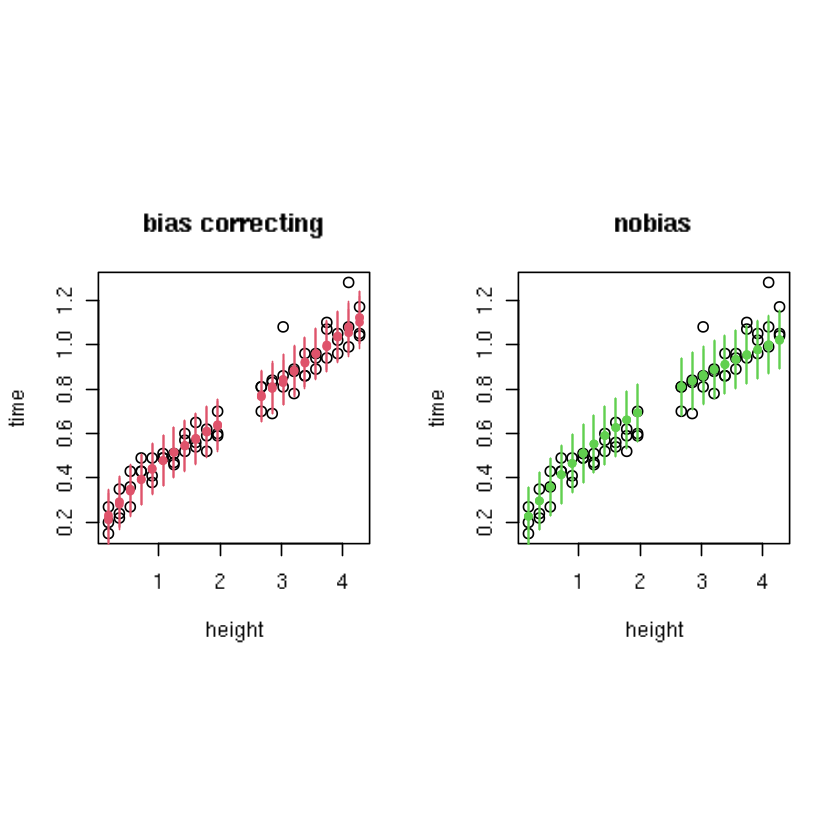

In [295]:
par(mfrow=c(1,2), pty="s")
plot(ball, main="bias correcting")
points(ball$height, m, col=2, pch=20)
segments(ball$height, q1, ball$height, q2, col=2)
plot(ball, main="nobias")
points(ball$height, mnb, col=3, pch=20)
segments(ball$height, q1nb, ball$height, q2nb, col=3)

In [296]:
b <- mean(- (ball$time - m)^2/s2 - log(s2))
nb <- mean(- (ball$time - mnb)^2/s2nb - log(s2nb))
scores <- c(bias=b, nobias=nb)
scores

bias   nobias 
4.205367 3.976545

In [297]:
library(plgp)

In [298]:
KM <- covar.sep(XU, d=mle$d, g=eps)
tau2M <- drop(t(yM) %*% solve(KM) %*% yM / length(yM))
SigmaM <- tau2M*KM

In [299]:
KB <- covar.sep(XF, d=bhat$theta[1], g=bhat$theta[2])
XFuhat <- cbind(XF, 
  matrix(rep(uhat, nrow(XF)), ncol=length(uhat), byrow=TRUE))
Ym <- predGPsep(yMhat, XFuhat, lite=TRUE)$mean
YmYm <- ball$time - Ym
tau2B <- drop(t(YmYm) %*% solve(KB) %*% YmYm / length(YmYm))
SigmaB <- tau2B * KB
deleteGPsep(yMhat)

In [300]:
ViVldet <- function(u, XU, XF, SigmaM, tau2M, mle, SigmaB)
 {
  ## build blocks
  XFu <- cbind(XF, u)
  SMXFu <- tau2M * covar.sep(XU, XFu, d=mle$d, g=0)
  SMu <- tau2M * covar.sep(XFu, d=mle$d, g=eps)

  ## build V from blocks
  V <- cbind(SigmaM, SMXFu)
  V <- rbind(V, cbind(t(SMXFu), SMu + SigmaB))

  ## return inverse and determinant
  ## (improvements possible with partitioned inverse equations)
  return(list(inv=solve(V), 
    ldet=as.numeric(determinant(V, log=TRUE)$modulus)))
 }


In [301]:
llik <- function(u, XU, yM, XF, yF, SigmaM, tau2M, mle, SigmaB)
 {
  V <- ViVldet(u, XU, XF, SigmaM, tau2M, mle, SigmaB)
  ll <- - 0.5*V$ldet
  Y <- c(yM, yF)
  ll <- ll - 0.5*drop(t(Y) %*% V$inv %*% Y)
  return(ll)
 }

In [302]:
formals(llik)[2:9] <- list(XU, yM, XF, ball$time, SigmaM, tau2M, 
  mle, SigmaB)

In [303]:
lprior <- function(u, shape1=1.1, shape2=1.1, lwr=-0.75, upr=2) 
 {
  u <- (u - lwr)/(upr - lwr)
  dbeta(u, shape1, shape2, log=TRUE)
 }

In [304]:
T <- 10000
lpost <- u <- rep(NA, T)
u[1] <- uhat
lpost[1] <- llik(u[1]) + lprior(u[1])

In [305]:
for(t in 2:T) {
  
  ## random walk Gaussian proposal
  u[t] <- rnorm(1, mean=u[t - 1], sd=0.3)
  lpu <- lprior(u[t])
  if(is.infinite(lpu)) { ## prior reject
    u[t] <- u[t - 1]
    lpost[t] <- lpost[t - 1]
    next
  }

  ## calculate log posterior
  lpost[t] <- llik(u[t]) + lpu

  ## Metropolis accept-reject calculation
  if(runif(1) > exp(lpost[t] - lpost[t - 1])) { ## MH reject
    u[t] <- u[t - 1]
    lpost[t] <- lpost[t - 1]
  }
 }

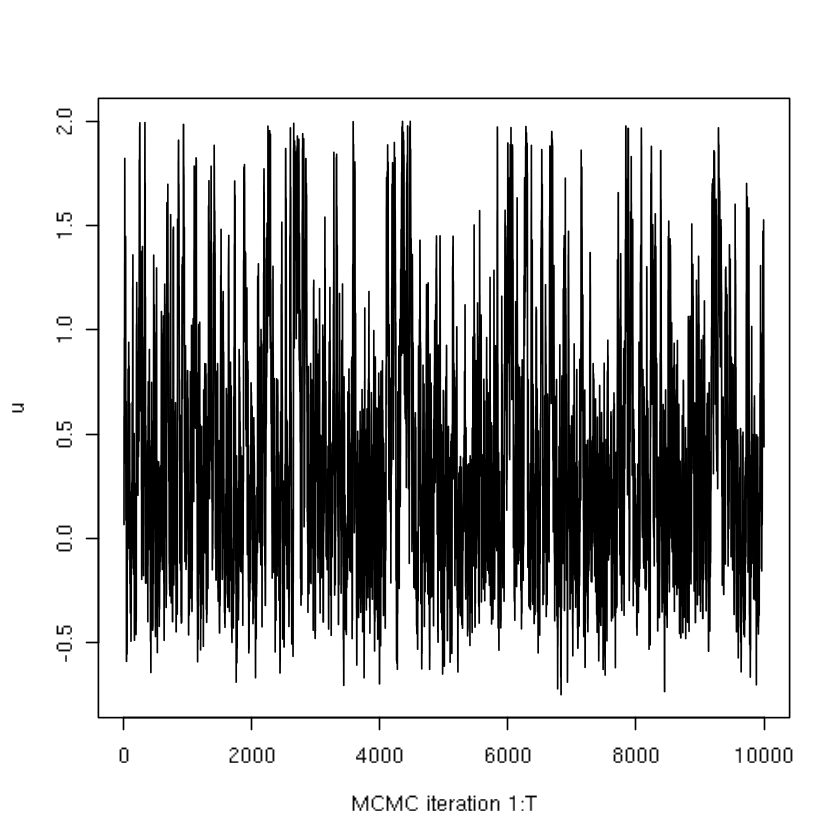

In [306]:
plot(u, type="l", xlab="MCMC iteration 1:T", ylab="u")

In [307]:
library(coda)
ess <- effectiveSize(u)
ess

var1 
379.4707

In [308]:
d <- density(u*diff(gr) + gr[1], from=0, to=22)

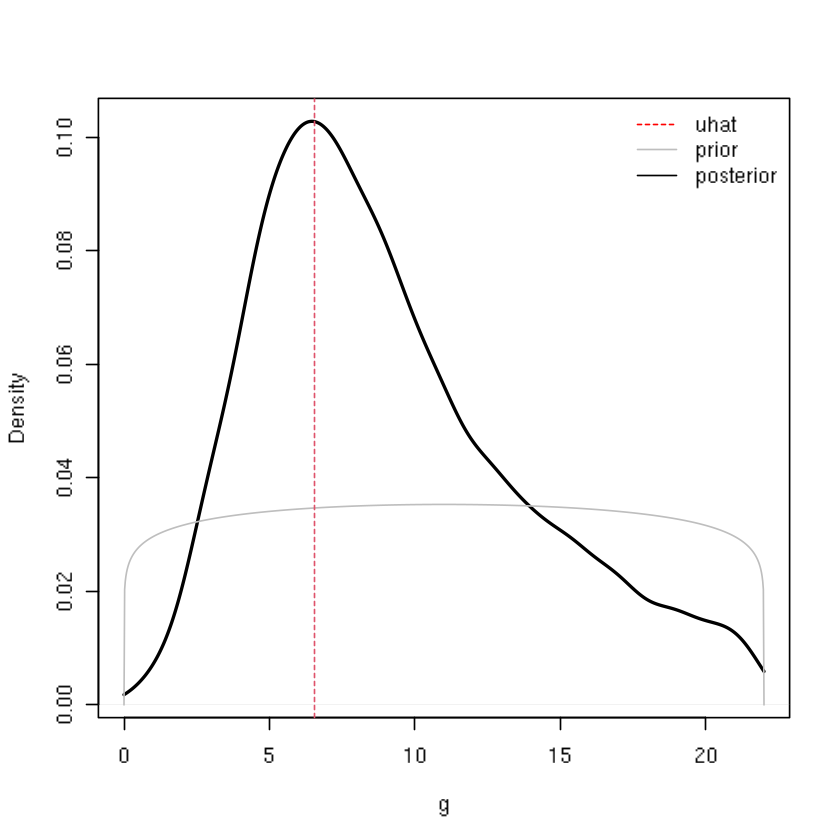

In [309]:
ugrid <- seq(-0.75, 2, length=1000)
ggrid <- ugrid*diff(gr) + gr[1]
lp <- lprior(ugrid)
plot(d, xlab="g", lwd=2, main="")
lines(ggrid, exp(lp)/30, col="gray")
abline(v=ghat, col=2, lty=2)
legend("topright", c("uhat", "prior", "posterior"), lty=c(2,1,1), 
  col=c("red", "gray", "black"), lwd=c(1,1,1,2), bty="n")

In [310]:
w <- which.max(lpost)
u[w]*diff(gr) + gr[1]

[1] 6.559398

### 8.2.2 Main effects

In [311]:
fried <- function (n, m=6)
 {
  if(m < 5) stop("must have at least 5 cols")
  X <- randomLHS(n, m)
  Ytrue <- 10*sin(pi*X[,1]*X[,2]) + 20*(X[,3] - 0.5)^2 + 10*X[,4] + 5*X[,5]
  Y <- Ytrue + rnorm(n, 0, 1)
  return(data.frame(X, Y, Ytrue))
 }

In [312]:
data <- fried(250)
gpi <- newGPsep(as.matrix(data[,1:6]), data$Y, d=0.1, 
  g=var(data$Y)/10, dK=TRUE)
mle <- mleGPsep(gpi, param="both", tmin=rep(eps, 2), 
  tmax=c(10, var(data$Y)))

In [313]:
N <- 10000
G <- 30  
m <- q1 <- q2 <- matrix(NA, ncol=6, nrow=G)
grid <- seq(0, 1, length=G)
XX <- matrix(NA, ncol=6, nrow=N)

In [314]:
for(j in 1:6) {
  for(i in 1:G) {
    XX[,j] <- grid[i]
    XX[,-j] <- randomLHS(N, 5)
    p <- predGPsep(gpi, XX, lite=TRUE, nonug=TRUE)
    m[i,j] <- mean(p$mean)
    q1[i,j] <- mean(qnorm(0.05, p$mean, sqrt(p$s2)))
    q2[i,j] <- mean(qnorm(0.95, p$mean, sqrt(p$s2)))
  }
}

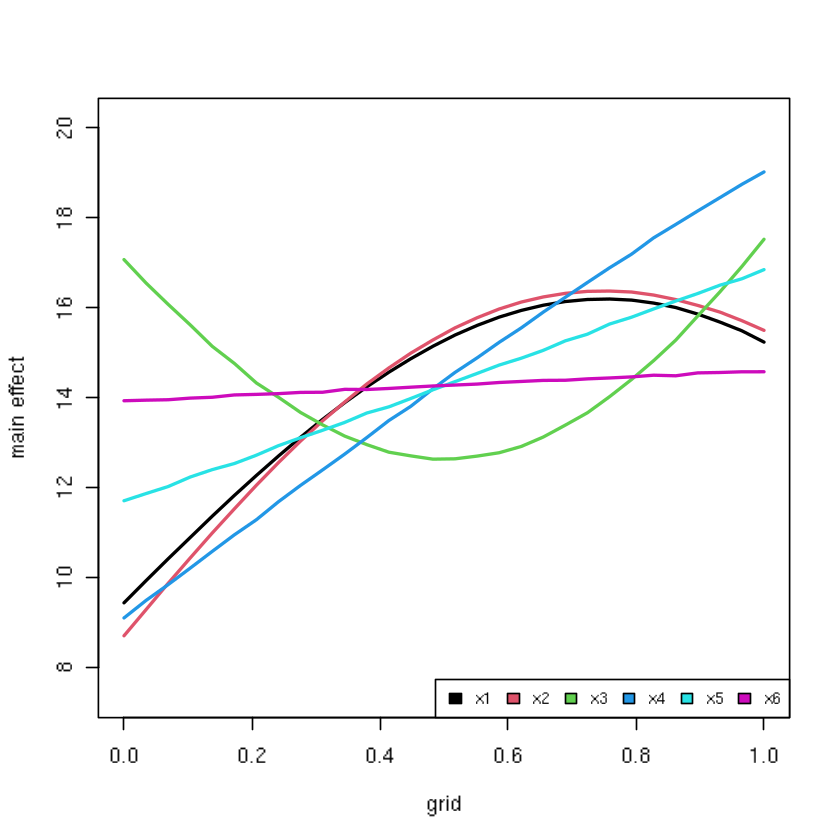

In [316]:
plot(0, xlab="grid", ylab="main effect", xlim=c(0,1), 
  ylim=range(c(q1,q2)), type="n")
for(j in 1:6) lines(grid, m[,j], col=j, lwd=2)
legend("bottomright", paste0("x", 1:6), fill=1:6, horiz=TRUE, cex=0.75)

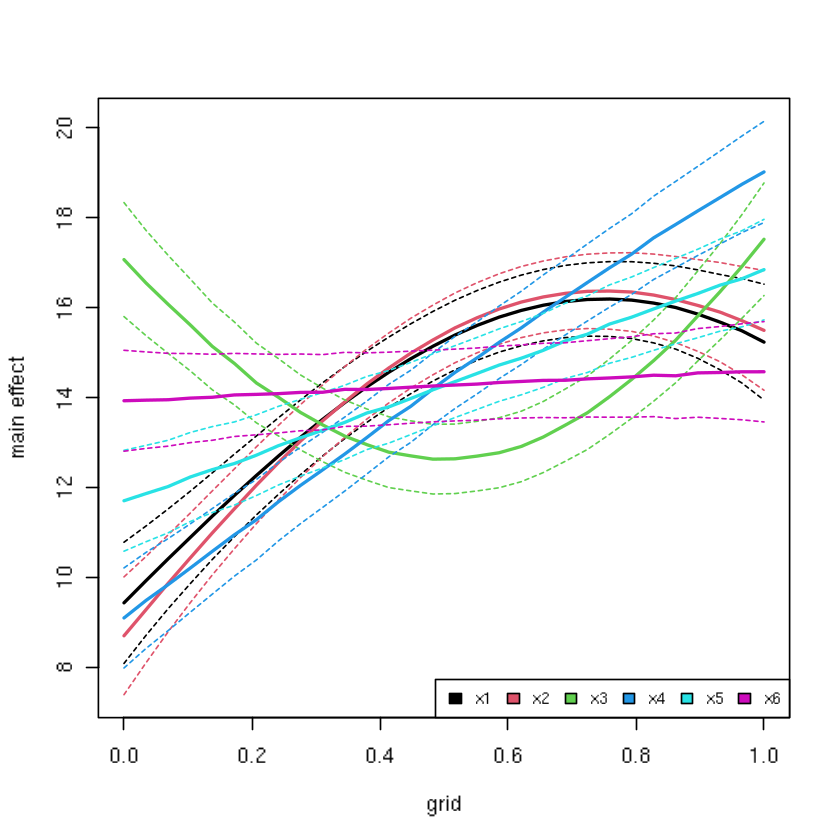

In [317]:
plot(0, xlab="grid", ylab="main effect", xlim=c(0,1), 
  ylim=range(c(q1,q2)), type="n")
for(j in 1:6) { 
  lines(grid, m[,j], col=j, lwd=2)
  lines(grid, q1[,j], col=j, lty=2)
  lines(grid, q2[,j], col=j, lty=2) 
}
legend("bottomright", paste0("x", 1:6), fill=1:6, horiz=TRUE, cex=0.75)

### 8.2.3 First-order and total sensitivity

In [318]:
M <- randomLHS(N, 6)
pM <- predGPsep(gpi, M, lite=TRUE, nonug=TRUE)
Ey <- mean(pM$mean)
Vary <- (t(pM$mean) %*% pM$mean)/N - Ey^2

In [319]:
Mprime <- randomLHS(N, 6)
S <- EE2j <- rep(NA, 6)
for(j in 1:6) {
  Mjprime <- Mprime
  Mjprime[,j] <- M[,j]
  pMprime <- predGPsep(gpi, Mjprime, lite=TRUE, nonug=TRUE)
  EE2j[j] <- (t(pM$mean) %*% pMprime$mean)/(N - 1)
  S[j] <- (EE2j[j] - Ey^2)/Vary
}

In [320]:
S

[1] 0.19563699 0.24406352 0.09569507 0.35838552 0.09992767 0.01407687

In [321]:
T <- EE2mj <- rep(NA, 6)
for(j in 1:6) {
  Mj <- M
  Mj[,j] <- Mprime[,j]
  pMj <- predGPsep(gpi, Mj, lite=TRUE, nonug=TRUE)
  EE2mj[j] <- (t(pM$mean) %*% pMj$mean)/(N - 1)
  T[j] <- 1 - (EE2mj[j] - Ey^2)/Vary
}
deleteGPsep(gpi)

In [322]:
T

[1] 0.234109237 0.283514054 0.084550641 0.350682577 0.083371794 0.001402159

In [323]:
I <- T-S
I[I < 0] <- 0
I

[1] 0.03847225 0.03945053 0.00000000 0.00000000 0.00000000 0.00000000

### 8.2.4 Bayesian sensitivity

In [325]:
library(tgp)